In [ ]:
#Visualise classification report

#Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import argparse
from tabulate import tabulate
import io
from PIL import Image
import os
import seaborn as sns

In [4]:
# Define base paths
try:
    BASE_DIR = os.path.abspath(os.path.join(os.path.dirname(__file__), '..', 'attack_simulation'))
except NameError:
    # __file__ is not defined (e.g., in Jupyter)
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'attack_simulation'))

DATA_DIR = os.path.join(BASE_DIR, "attack_simulation_results")
OUTPUT_DIR = os.path.join(BASE_DIR, "attack_simulation_viz")
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [9]:
def load_csv_data():
    """
    Parameters:
    filename (str): Name of the CSV files to read, defaults to "attack_results_fgsm_summary.csv" and "attack_results_pgd_summary"
    
    Returns:
    pandas.DataFrame: The data from the CSV files
    """

    """Load necessary resources for visualisation"""
    fgsm= os.path.join(DATA_DIR, "attack_results_fgsm_summary.csv")
    pgd = os.path.join(DATA_DIR, "attack_results_pgd_summary.csv")

    try:
        # Read the CSV file into a pandas DataFrame
        df_fgsm = pd.read_csv(fgsm)
        df_pgd = pd.read_csv(pgd)
        return df_fgsm, df_pgd
    except FileNotFoundError:
        print(f"Error: File '{fgsm}' not found in the current directory.")
        print(f"Error: File '{pgd}' not found in the current directory.")
        return None
    except Exception as e:
        print(f"Error loading CSV data: {e}")
        return None

In [10]:
df_fgsm, df_pgd = load_csv_data()

In [11]:
print(df_fgsm.columns)
print(df_pgd.columns)

Index(['Classifier', 'Epsilon', 'Accuracy', 'Precision', 'Recall', 'F1-score'], dtype='object')
Index(['Classifier', 'Epsilon', 'Accuracy', 'Precision', 'Recall', 'F1-score'], dtype='object')


In [ ]:
def create_model_results_table():
    """
    Create a visualization table of model evaluation metrics.
    
    Parameters:
    -----------
    model_results : pandas DataFrame
        DataFrame containing precision, recall, f1-score, accuracy, and training_time
    
    Returns:
    --------
    PIL.Image.Image
        PNG image of the visualization table
    """
    # Create a copy to avoid modifying the original dataframe
    df_fgsm1, df_pgd1 = load_csv_data()

    #Create a visualisation to show FGSM attack results after PGD
     # Set up the style
    sns.set_style("whitegrid")
    
    # Create a figure for the table at the top
    fig = plt.figure(figsize=(14, 14))  # Increased height to accommodate table
    
    # Create a layout with a table at top and 2x2 subplots below
    gs = fig.add_gridspec(5, 2, height_ratios=[1, 2, 2, 2, 2])
    
    # Create a table spanning the top row
    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis('off')  # Hide axes for table
    
    # Format the data for the table - round numeric values
    table_data = df_fgsm1.copy()
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
        table_data[col] = table_data[col].round(3)
    
    # Create the table
    table = ax_table.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)  # Adjust table size
    
    # Add title above the table
    ax_table.set_title('FGSM Attack Results Summary', fontsize=16, pad=20)
    
    # Define metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    # Create another visualization: combined line plot for LogisticRegression metrics with table
    fig_line = plt.figure(figsize=(12, 10))  # Increased height for table
    
    # Create a layout with table at top and line chart below
    gs_line = fig_line.add_gridspec(2, 1, height_ratios=[1, 3])
    
    # Create a table for LogisticRegression results
    ax_lr_table = fig_line.add_subplot(gs_line[0, 0])
    ax_lr_table.axis('off')  # Hide axes for table
    
    # Filter data for just LogisticRegression
    lr_df = df_fgsm1[df_fgsm1['Classifier'] == 'LogisticRegression']
    
    # Format the data for the table - round numeric values
    lr_table_data = lr_df.copy()
    lr_table_data = lr_table_data.drop(columns=['Classifier'])  # Remove redundant column
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
        lr_table_data[col] = lr_table_data[col].round(3)
    
    # Create the table
    lr_table = ax_lr_table.table(
        cellText=lr_table_data.values,
        colLabels=lr_table_data.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    # Style the table
    lr_table.auto_set_font_size(False)
    lr_table.set_fontsize(10)
    lr_table.scale(1, 1.5)  # Adjust table size
    
    # Add title above the table
    ax_lr_table.set_title('LogisticRegression Results Summary - FGSM', fontsize=16, pad=20)
    
    # Create line chart below the table
    ax_line = fig_line.add_subplot(gs_line[1, 0])
    
    for metric in metrics:
        ax_line.plot(lr_df['Epsilon'], lr_df[metric], marker='o', linewidth=2, label=metric)

    ax_line.set_title('LogisticRegression Performance Metrics vs Epsilon - FGSM', fontsize=16)
    ax_line.set_xlabel('Epsilon', fontsize=14)
    ax_line.set_ylabel('Score', fontsize=14)
    ax_line.grid(True, linestyle='--', alpha=0.7)
    ax_line.legend(fontsize=12)
    ax_line.set_xticks(lr_df['Epsilon'])
    ax_line.set_ylim(-0.05, 1.05)  # Set y-axis limits

    #Create a second visualisation to show PGD attach results after LogisticRegression
     # Set up the style
    sns.set_style("whitegrid")
    
    # Create a figure for the table at the top
    fig = plt.figure(figsize=(14, 14))  # Increased height to accommodate table
    
    # Create a layout with a table at top and 2x2 subplots below
    gs = fig.add_gridspec(5, 2, height_ratios=[1, 2, 2, 2, 2])
    
    # Create a table spanning the top row
    ax_table = fig.add_subplot(gs[0, :])
    ax_table.axis('off')  # Hide axes for table
    
    # Format the data for the table - round numeric values
    table_data = df_pgd.copy()
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
        table_data[col] = table_data[col].round(3)
    
    # Create the table
    table = ax_table.table(
        cellText=table_data.values,
        colLabels=table_data.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 1.5)  # Adjust table size
    
    # Add title above the table
    ax_table.set_title('PGD Attack Results Summary', fontsize=16, pad=20)
    
    # Define metrics
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']

    # Create another visualization: combined line plot for LogisticRegression metrics with table
    fig_line = plt.figure(figsize=(12, 10))  # Increased height for table
    
    # Create a layout with table at top and line chart below
    gs_line = fig_line.add_gridspec(2, 1, height_ratios=[1, 3])
    
    # Create a table for LogisticRegression results
    ax_lr_table = fig_line.add_subplot(gs_line[0, 0])
    ax_lr_table.axis('off')  # Hide axes for table
    
    # Filter data for just LogisticRegression
    lr_df = df_pgd[df_pgd['Classifier'] == 'LogisticRegression']
    
    # Format the data for the table - round numeric values
    lr_table_data = lr_df.copy()
    lr_table_data = lr_table_data.drop(columns=['Classifier'])  # Remove redundant column
    for col in ['Accuracy', 'Precision', 'Recall', 'F1-score']:
        lr_table_data[col] = lr_table_data[col].round(3)
    
    # Create the table
    lr_table = ax_lr_table.table(
        cellText=lr_table_data.values,
        colLabels=lr_table_data.columns,
        cellLoc='center',
        loc='center',
        bbox=[0, 0, 1, 1]
    )
    
    # Style the table
    lr_table.auto_set_font_size(False)
    lr_table.set_fontsize(10)
    lr_table.scale(1, 1.5)  # Adjust table size
    
    # Add title above the table
    ax_lr_table.set_title('LogisticRegression Results Summary - PGD', fontsize=16, pad=20)
    
    # Create line chart below the table
    ax_line = fig_line.add_subplot(gs_line[1, 0])
    
    for metric in metrics:
        ax_line.plot(lr_df['Epsilon'], lr_df[metric], marker='o', linewidth=2, label=metric)

    ax_line.set_title('LogisticRegression Performance Metrics vs Epsilon - PGD', fontsize=16)
    ax_line.set_xlabel('Epsilon', fontsize=14)
    ax_line.set_ylabel('Score', fontsize=14)
    ax_line.grid(True, linestyle='--', alpha=0.7)
    ax_line.legend(fontsize=12)
    ax_line.set_xticks(lr_df['Epsilon'])
    ax_line.set_ylim(-0.05, 1.05)  # Set y-axis limits

    # Save and show
    filename = 'model_results.png'
    save_path = os.path.join(OUTPUT_DIR, filename)
    fig.savefig(save_path, dpi=300, bbox_inches='tight', pad_inches=0.5, facecolor='white')
    plt.show()
    print("Main visualization completed and saved to 'model_results.png'")
    
    return fig

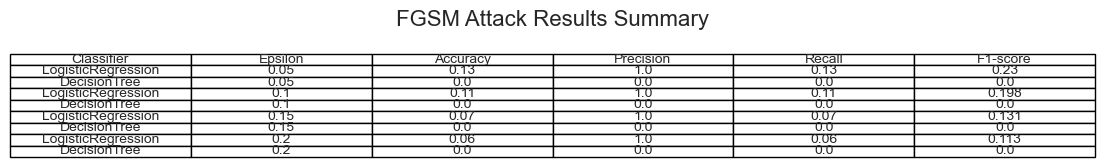

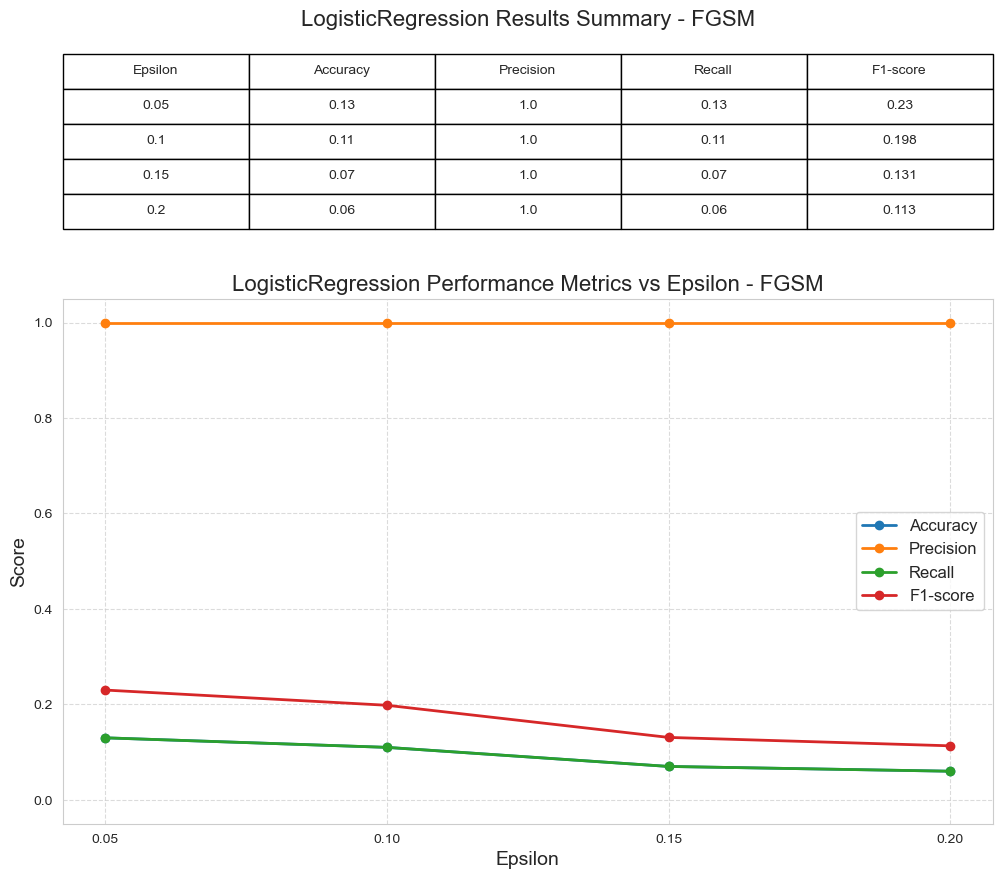

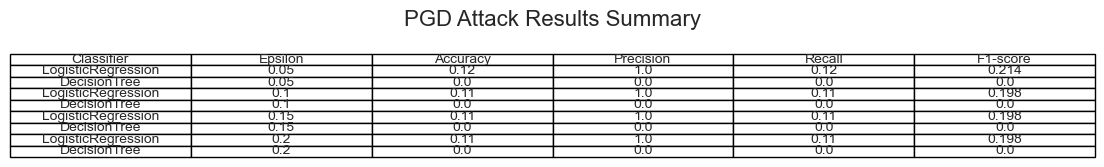

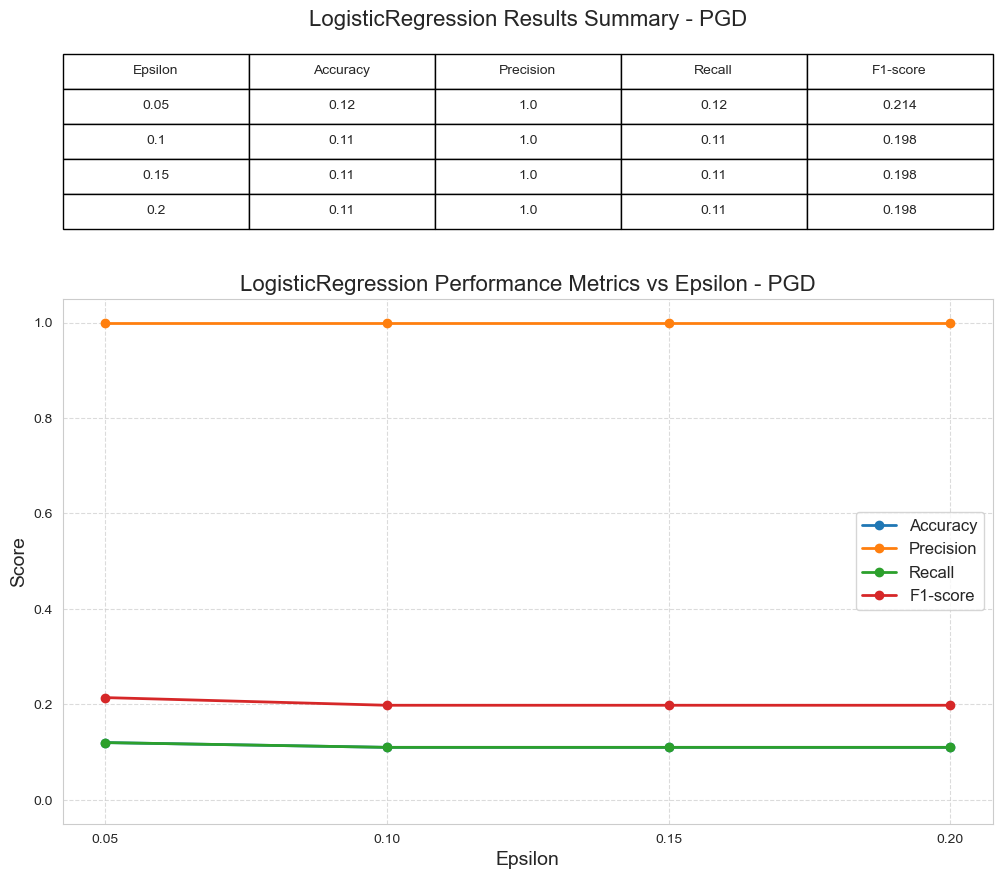

Main visualization completed and saved to 'concept_drift_analysis.png'


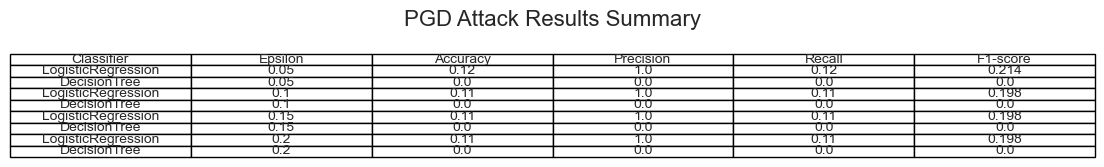

In [18]:
create_model_results_table()

In [ ]:
def create_model_results_table_old(model_results):
    """
    Create a visualization table of model evaluation metrics.
    
    Parameters:
    -----------
    model_results : pandas DataFrame
        DataFrame containing precision, recall, f1-score, accuracy, and training_time
    
    Returns:
    --------
    PIL.Image.Image
        PNG image of the visualization table
    """
    # Create a copy to avoid modifying the original dataframe
    df = model_results.copy()

    # Add model index for identification
    df['training'] = [f"Training Run {i+1}" for i in range(len(df))]
    
    # Calculate average training time - safely handle different data structures
    #if len(df) == 1:
        # If there's only one row
     #   avg_training_time = df['training_time'].iloc[0]
    #else:
        # If there are multiple rows
    #    avg_training_time = pd.Series(df['training_time']).mean()

    # Select columns for visualization
    metrics_df = df[['training', 'precision', 'recall', 'f1-score', 'accuracy']]
    
    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Remove axes
    ax.axis('tight')
    ax.axis('off')
    
    # Create the table
    metrics_data = metrics_df.values.tolist()  # Convert to list for better compatibility
    column_headers = ['Training Run', 'Precision', 'Recall', 'F1-Score', 'Accuracy']
    
    # Format numeric values
    for i in range(len(metrics_data)):
        for j in range(1, 5):  # Skip the model name column
            metrics_data[i][j] = f"{float(metrics_data[i][j]):.2f}"
    
    table = ax.table(
        cellText=metrics_data,
        colLabels=column_headers,
        loc='center',
        cellLoc='center',
        colColours=['#e6e6e6'] * 5
    )
    
    # Add a row for training time at the bottom
    #bottom_row = table.add_cell(len(metrics_data), 0, 
    #                          width=1, height=0.2, 
    #                          text='Average Training Time',
    #                          loc='center')
    
   # # Add training time value
   # time_cell = table.add_cell(len(metrics_data), 1, 
   #                           width=4, height=0.2, 
   #                           text=f"{avg_training_time:.2f} seconds",
   #                           loc='center')
    
    # Style the table
    table.auto_set_font_size(False)
    table.set_fontsize(12)
    table.scale(1, 1.5)
    
    # Apply simple alternating row coloring for readability
    for i in range(len(metrics_data)):
        row_color = '#f2f2f2' if i % 2 == 0 else 'white'
        for j in range(len(metrics_data[i])):  # Use actual length of row
            try:
                cell = table[(i+1, j)]  # +1 because of the header row
                cell.set_facecolor(row_color)
            except KeyError:
                # Skip if cell doesn't exist
                continue
    
    # Style the bottom row
    #bottom_row.set_facecolor('#e6e6e6')
    #time_cell.set_facecolor('#e6e6e6')
    
    # Add a title
    plt.title('Model Evaluation Metrics', fontsize=16, pad=20)
    
    # Adjust layout
    plt.tight_layout()
    
    # Convert plot to image
    buf = io.BytesIO()
    plt.savefig(buf, format='png', dpi=300, bbox_inches='tight')
    buf.seek(0)
    img = Image.open(buf)
    
    return img

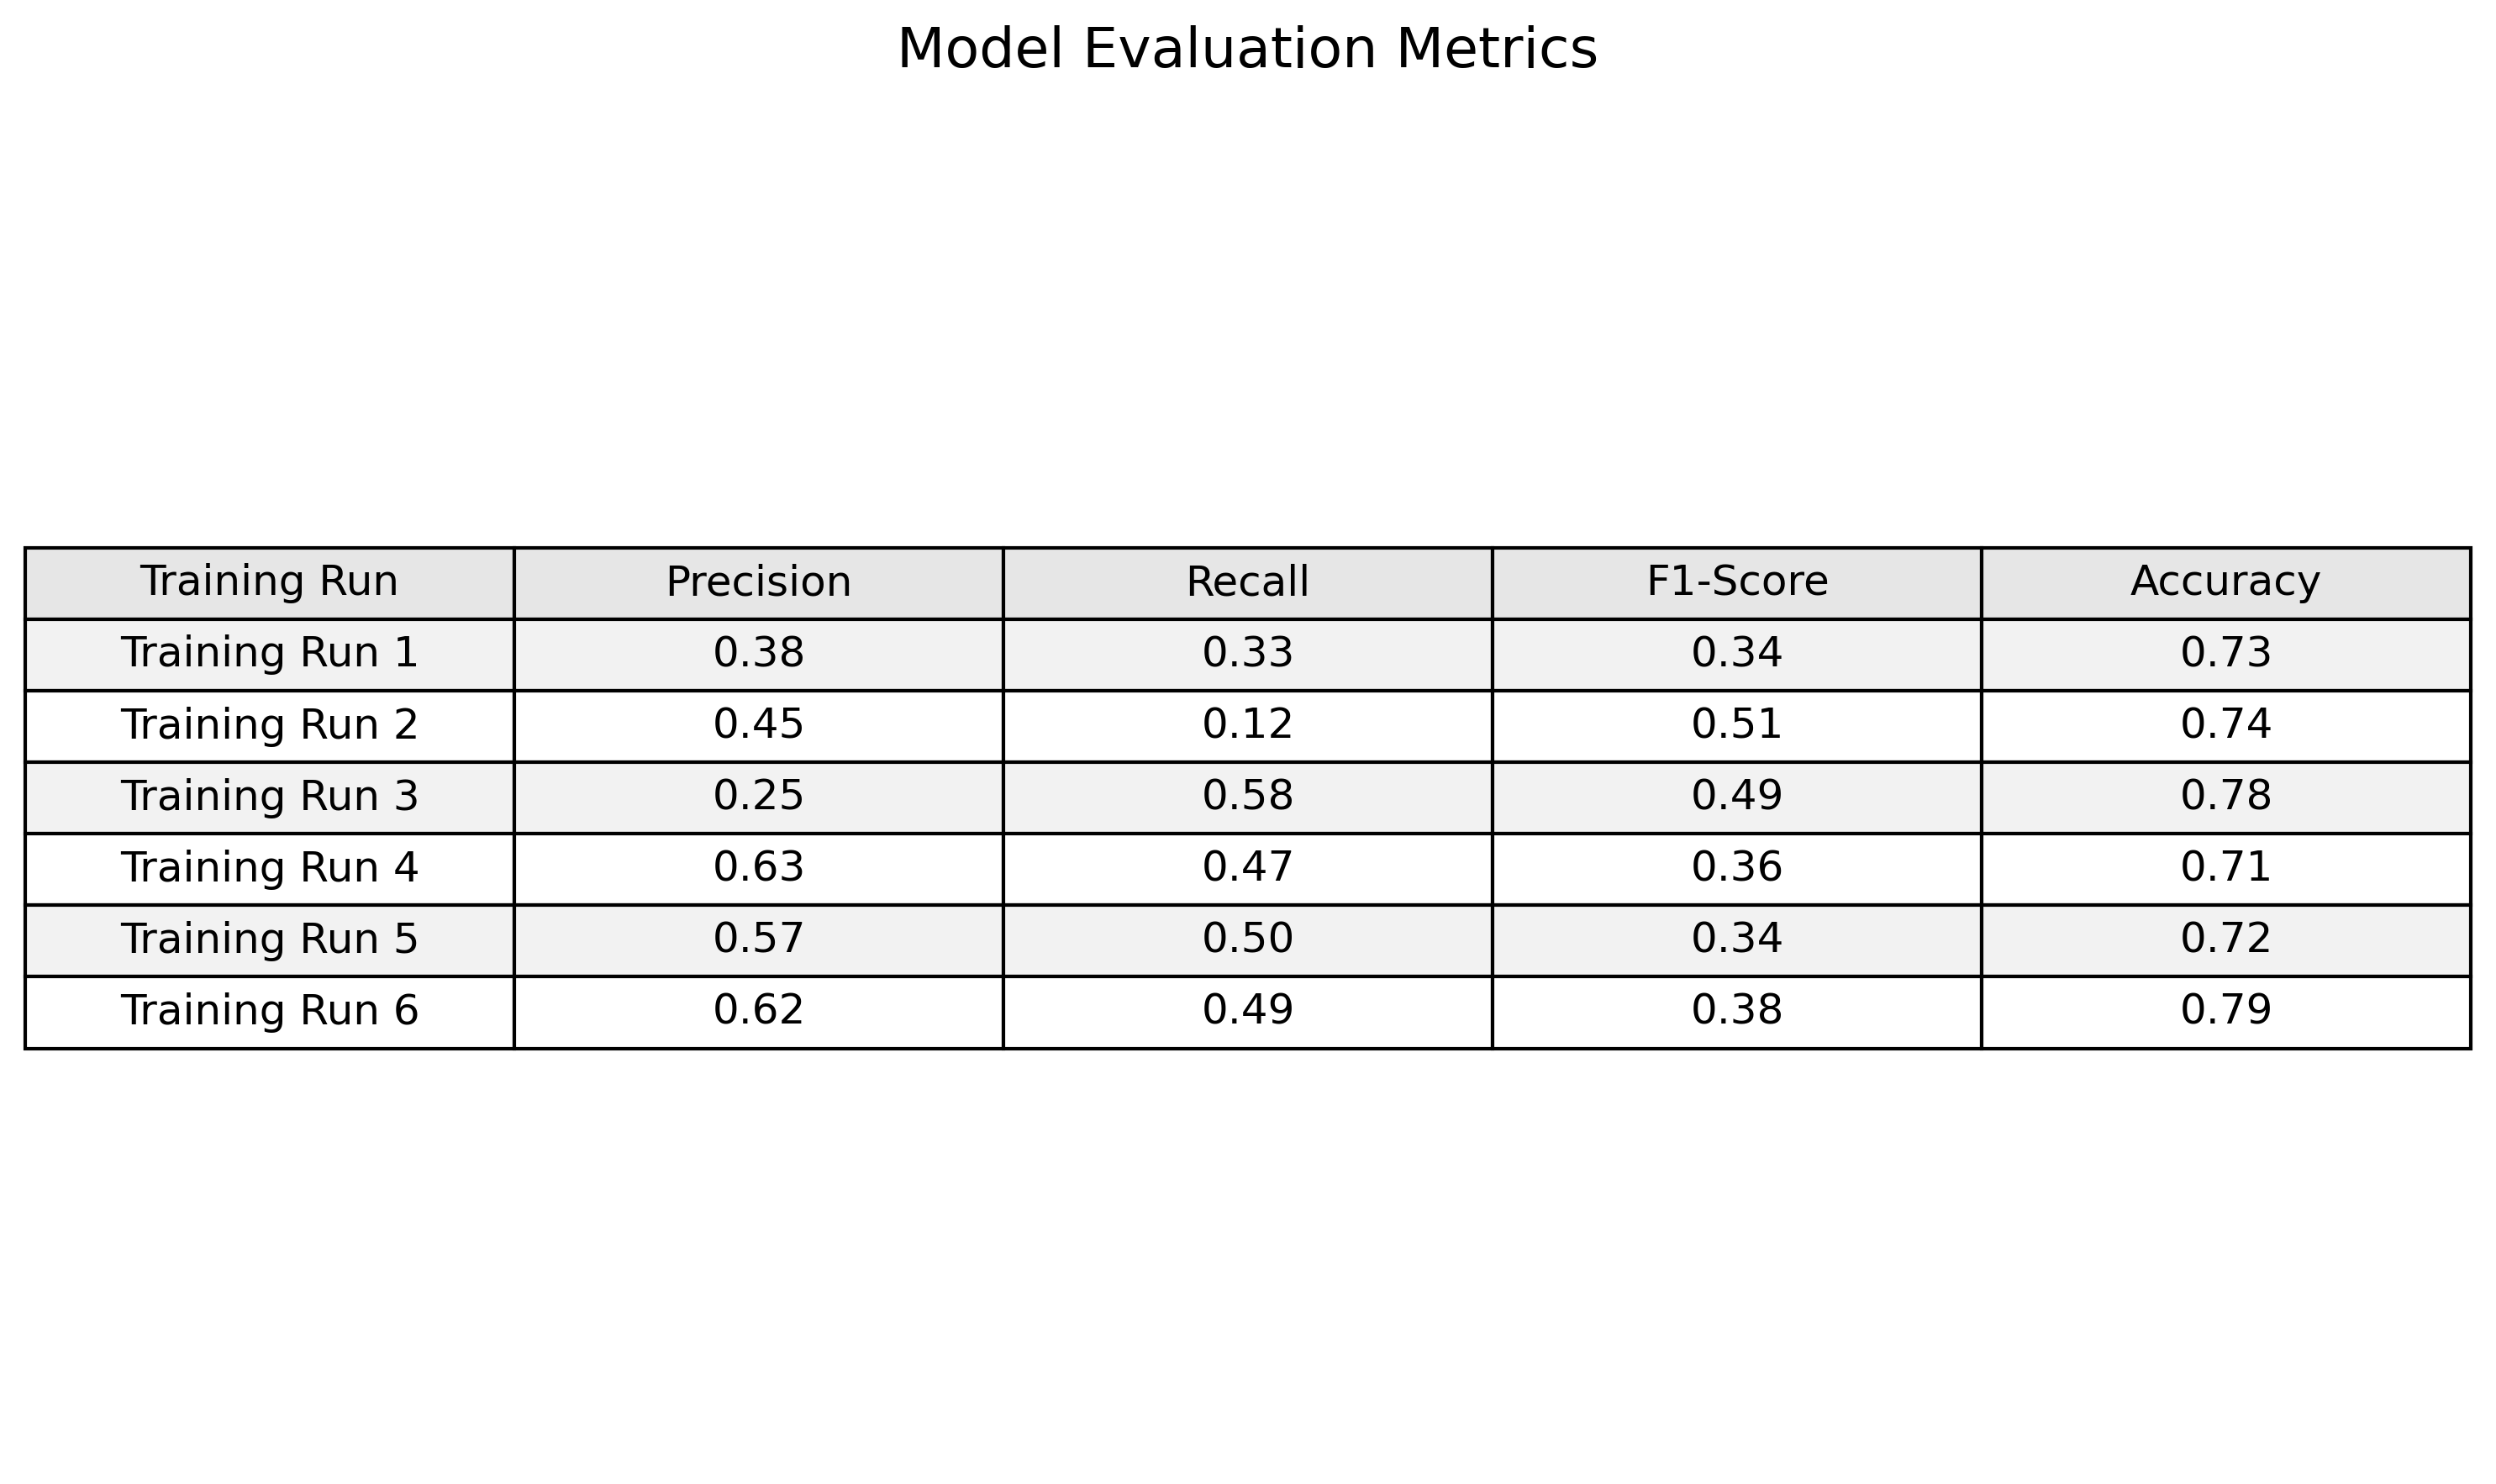

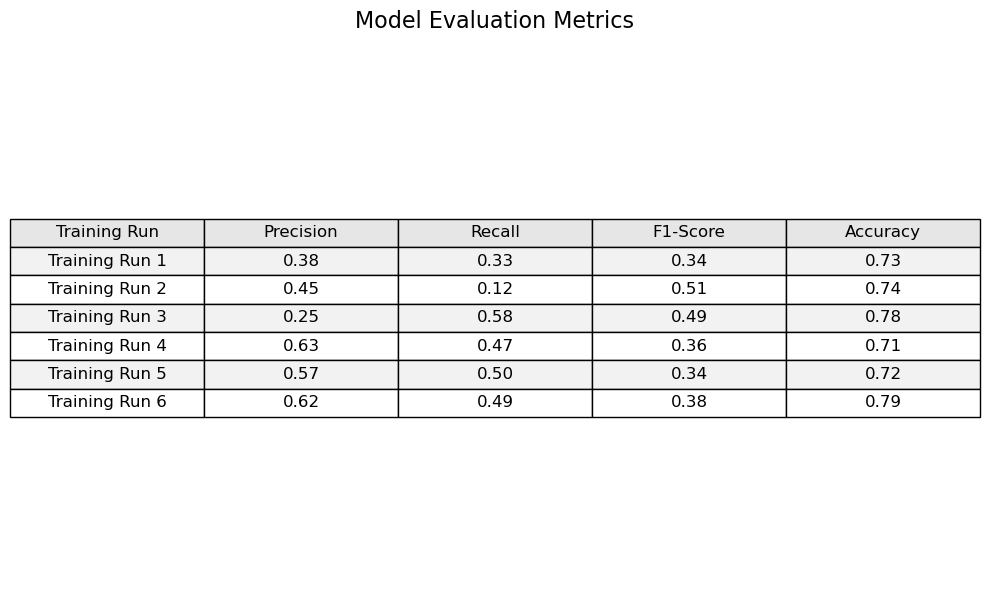

In [22]:
create_model_results_table(model_results)